In [1]:
import os
import sys
import pandas as pd
import numpy as np
from phandas import *
from phandas import ic as ph_ic 
from binance_data_loader import BinanceDataLoader

In [2]:
# ------------------- user parameters -------------------
DATA_DIR = r"C:\Users\USER\Documents\Binance_related\dailytickerdata2020"     # e.g. "/data/binance/1d/"
                             # momentum lookback in trading days
HOLDING = 1                               # holding period (rebalance daily on next day close)
COST_BPS = 4.5                            # one-way transaction cost in bps
MIN_RECORDS = 252                         # ensure decent history per symbol
MIN_VOL_30D = 1e6 

# ------------------- load cross-sectional data -------------------
loader = BinanceDataLoader(
    data_directory=DATA_DIR,
    min_records=MIN_RECORDS,
    min_volume=1e5,
    start_date="2022-01-01",
    end_date=None
)

price_matrix = loader.get_price_matrix()   

Loading Binance data from C:\Users\USER\Documents\Binance_related\dailytickerdata2020...
Found 567 USDT trading pairs
✓ BTCUSDT loaded successfully with 1383 records, avg volume: 347,594
Loaded 377 cryptocurrencies
Filtered 188 cryptocurrencies (insufficient data/volume)
Precomputing returns matrix (FAST numpy version)...
Building returns matrix for 376 tickers over 1383 dates...
Precomputed returns matrix shape: (1383, 376)
Date range: 2022-01-01 00:00:00 to 2025-10-14 00:00:00


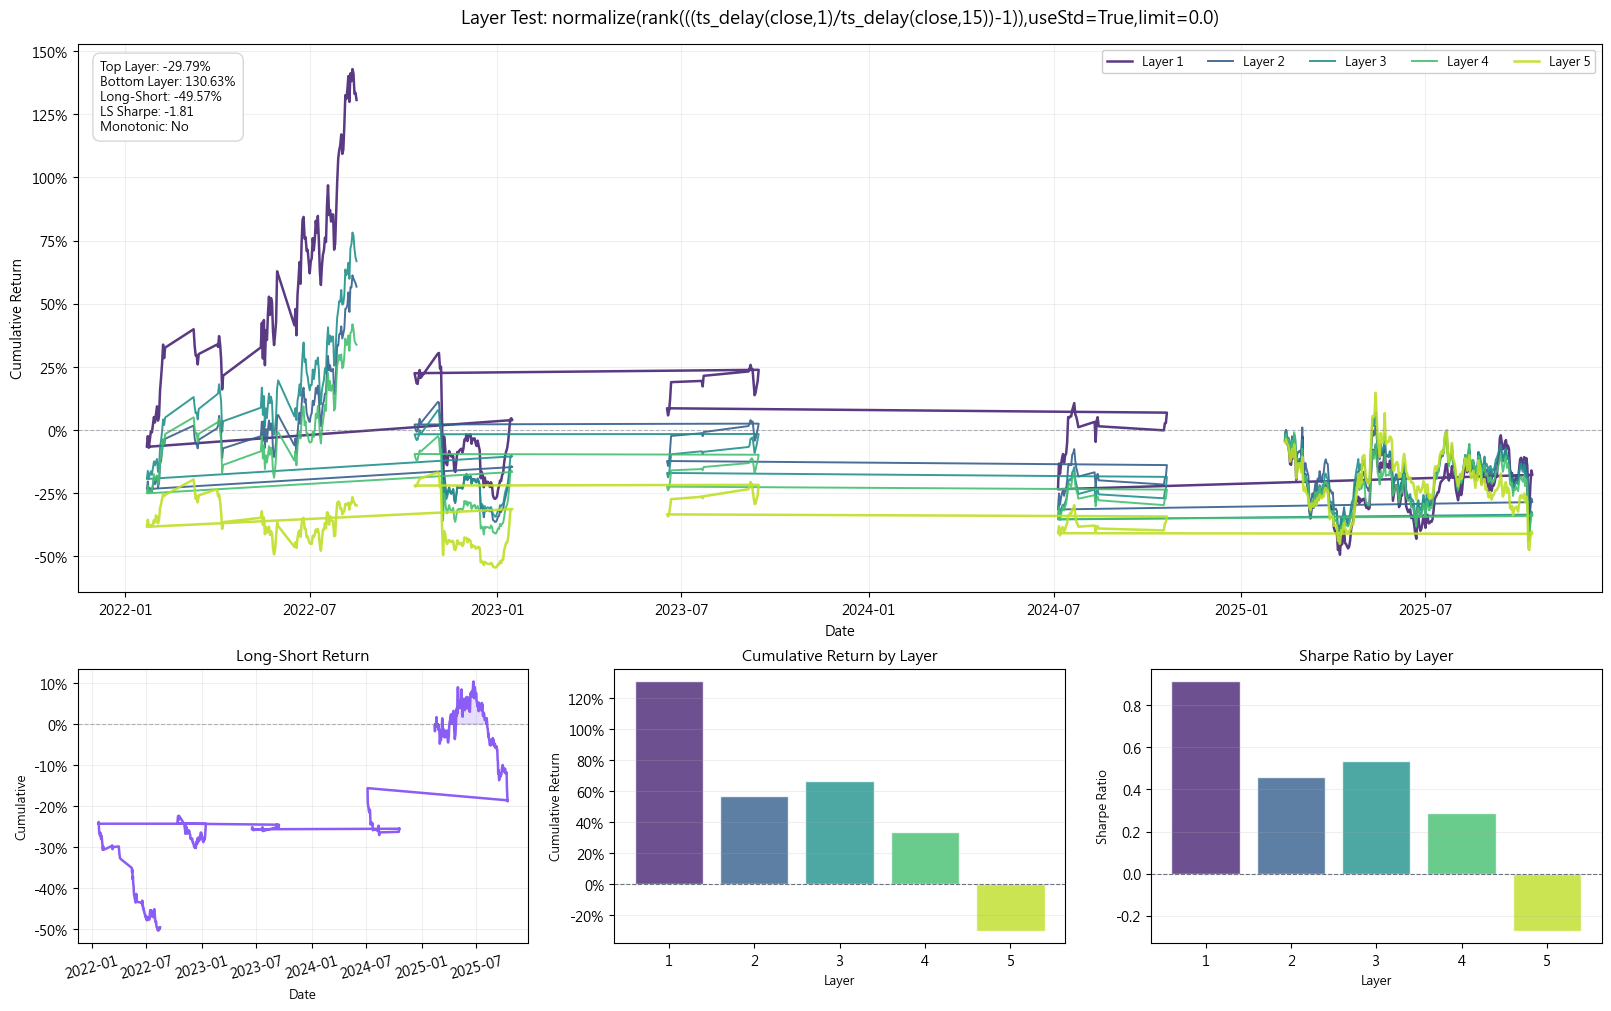

In [3]:
# ------------------- fit into Factor (phandas) format -------------------
# Factor expects a long 3-col frame: [timestamp, symbol, factor]
price_long = price_matrix.stack().rename("factor").reset_index()
price_long.columns = ["timestamp", "symbol", "factor"]
price = Factor(price_long, name="close")          # price factor
# ------------------- build momentum factor -------------------
# simple lookback (close / close_{t-LB} - 1). The ts_delay() aligns exactly.
mom = (price.ts_delay(1) / price.ts_delay(15)) - 1      # still a Factor

# Optional: cross-sectional cleanup before backtest
# - rank to remove scale, zscore to standardize
# - you can also clip extremes via normalize(limit=...) if desired
signal = mom.rank().zscore() 

# ------------------- layer analysis (factor monotonicity) -------------------
# This tests if higher momentum → higher next-period returns, using equal-weighted quantile portfolios.
results = analyze_layers(
    factor=signal,              # stratification factor
    price=price,                # to compute next-period returns
    n_layers=5,
    periods=HOLDING,
    y_scale="auto"
)

Strategy: normalize(rank(((ts_delay(close,1)/ts_delay(close,15))-1)),useStd=True,limit=0.0)
Period: 2022-01-22 to 2025-10-14
Total Return: -34.81%
Annual Return: -10.84%
Sharpe Ratio: -1.08
Max Drawdown: -36.43%
Avg. Annual Turnover: 14586.26%


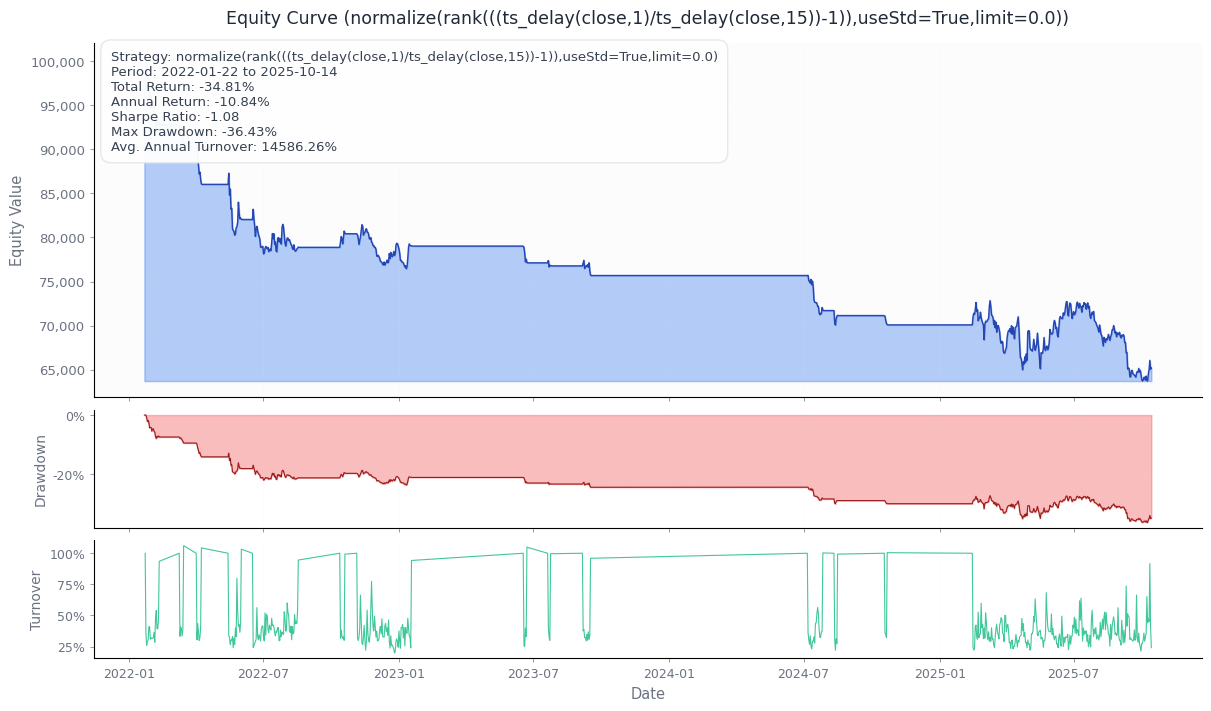

Backtester(strategy=normalize(rank(((ts_delay(close,1)/ts_delay(close,15))-1)),useStd=True,limit=0.0), period=2022-01-22 to 2025-10-14, days=1362)

In [4]:
bt = backtest(
    price_factor=price,
    strategy_factor=signal,
    transaction_cost=(COST_BPS/1e4, COST_BPS/1e4),
    initial_capital=100_000,
    auto_run=True,                                   # run + compute metrics
)

print(bt.summary())
bt.plot_equity(figsize=(12, 7), show_summary=True)

In [5]:
print("\n=== Backtest Summary ===")
print(bt.summary())
# bt.plot_equity(figsize=(12, 6), show_summary=True)  # uncomment to visualize

# -------------------- IC analytics (phandas ic module) --------------------
# 1) Daily Rank-IC at horizon=1
ric = ph_ic.rank_ic(signal=signal, price=price, horizon=1)  # pd.Series by date
ic_mean = float(ric.mean())
ic_std  = float(ric.std(ddof=1))
ic_ir   = ic_mean / (ic_std + 1e-12)
print("\n=== IC (h=1) ===")
print(f"Mean Rank-IC: {ic_mean:.4f} | Std: {ic_std:.4f} | IR: {ic_ir:.3f}")

# 2) IC-decay across horizons
ic_decay = ph_ic.ic_decay(signal=signal, price=price, horizons=HORIZONS)
print("\n=== IC Decay (mean Rank-IC by horizon) ===")
print(ic_decay)

# 3) IC by layers (e.g., quintiles)
ic_layers = ph_ic.ic_by_layer(signal=signal, price=price, n_layers=N_LAYERS, horizon=1)
print(f"\n=== IC by {N_LAYERS} Layers (h=1) ===")
print(ic_layers)

# (Optional) quick plots if your ic module exposes them:
# ph_ic.plot_ic(ric)
# ph_ic.plot_ic_decay(ic_decay)
# ph_ic.plot_ic_by_layer(ic_layers)

# -------------------- Layer return analysis (optional) --------------------
# Confirms monotonicity in realized returns via equal-weighted layer portfolios
layers_res = analyze_layers(
    factor=signal, 
    price=price, 
    n_layers=N_LAYERS, 
    periods=HOLDING, 
    y_scale="auto"
)
print("\n=== Layer Analysis Summary ===")
print(layers_res.get("summary", "no summary"))
# layers_res may also contain 'long_short_stats' and plotting handles


=== Backtest Summary ===
Strategy: normalize(rank(((ts_delay(close,1)/ts_delay(close,15))-1)),useStd=True,limit=0.0)
Period: 2022-01-22 to 2025-10-14
Total Return: -34.81%
Annual Return: -10.84%
Sharpe Ratio: -1.08
Max Drawdown: -36.43%
Avg. Annual Turnover: 14586.26%


AttributeError: module 'phandas.ic' has no attribute 'rank_ic'

In [ ]:
import sys, platform, numpy as np
print(sys.executable)
print(platform.python_version())
print(np.__version__)
